# Exercise 7
#### Lars Kühmichel, Nicolas Wolf

## 4. Fitting circles

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import coo_matrix, load_npz
from scipy.sparse.linalg import lsqr
from scipy import ndimage

''

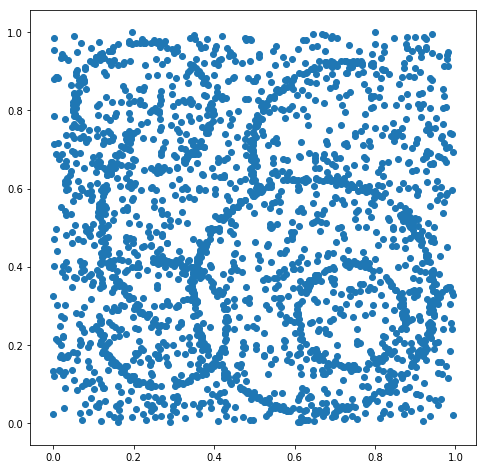

In [31]:
data = np.load("circles.npy")
plt.figure(figsize=(8,8))
plt.scatter(data[:,0], data[:,1])

You can see 4 full circles and two circle segments.

0
inlier count: 291
1
inlier count: 113
2
inlier count: 109
3
inlier count: 106
4
inlier count: 102
5
inlier count: 101
[0.30005348 0.33244771 0.15974162 0.24209853 0.13103715 0.16961319]
[[0.6484214  0.32581953]
 [0.45128993 0.52307549]
 [0.27298081 0.25659129]
 [0.73306792 0.6812261 ]
 [0.73890922 0.27145613]
 [0.22311605 0.80604326]]


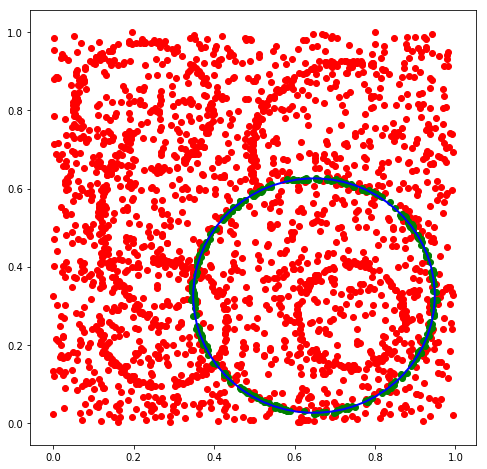

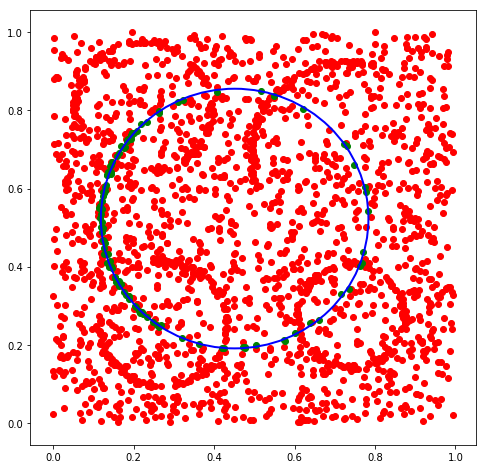

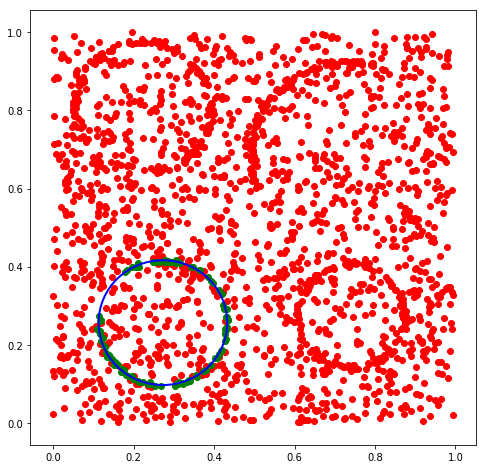

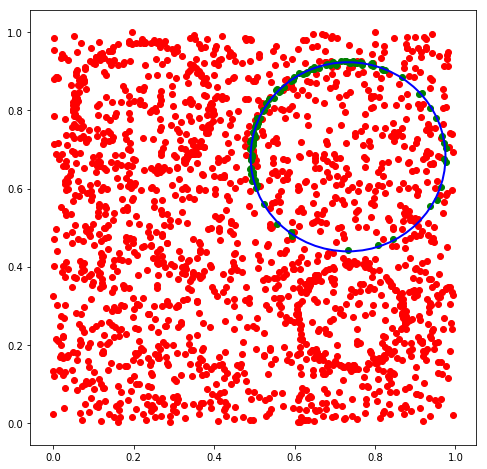

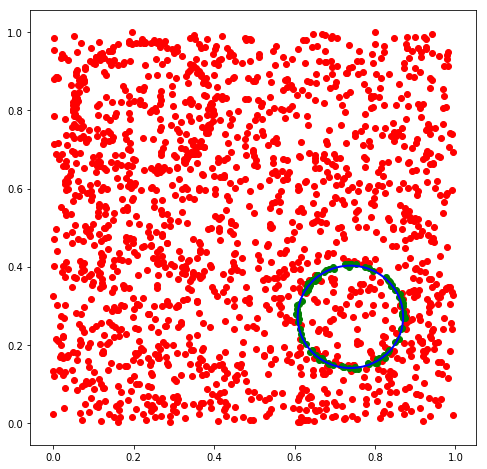

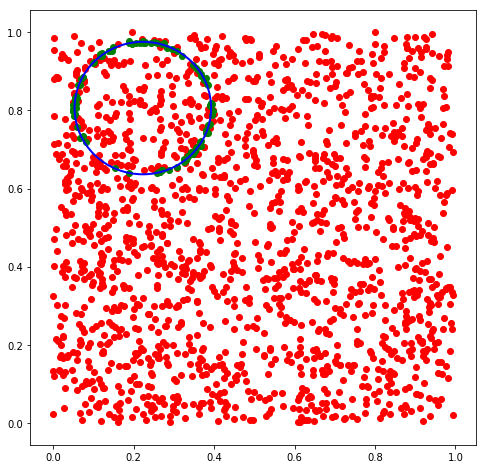

In [146]:
N = 50000
epsilon = 0.005
new_data = data.copy()

num_circles = 6
radii = np.zeros(num_circles)
all_center = np.zeros((6,2))

for i in range(num_circles):
    print(i)
    best_inlier_count = 0
    inlier_mask = None
    best_center = None
    best_radius = None

    for n in range(N):
        points = new_data[np.random.choice(new_data.shape[0], 3, replace=False)]
        A, B, C = points
        D = 2 * (A[0]*(B[1] - C[1]) + B[0]*(C[1] - A[1]) + C[0]*(A[1] - B[1]))
        Ux = ((A[0]**2 + A[1]**2)*(B[1] - C[1]) + (B[0]**2 + B[1]**2)*(C[1] - A[1]) + (C[0]**2 + C[1]**2)*(A[1] - B[1])) / D
        Uy = ((A[0]**2 + A[1]**2)*(C[0] - B[0]) + (B[0]**2 + B[1]**2)*(A[0] - C[0]) + (C[0]**2 + C[1]**2)*(B[0] - A[0])) / D
        U = np.array([Ux, Uy])
        radius = np.sqrt((Ux-A[0])**2 + (Uy-A[1])**2)

        distances = np.abs(radius - np.linalg.norm(new_data - U, axis=1))
        mask = distances < epsilon

        inlier_count = mask.sum()

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            inlier_mask = mask
            best_center = U
            best_radius = radius

    print(f"inlier count: {best_inlier_count}")
    radii[i] = best_radius
    all_center[i] = best_center
            
    plt.figure(figsize=(8,8))
    plt.scatter(new_data[~inlier_mask][:,0], new_data[~inlier_mask][:,1], color="red")
    plt.scatter(new_data[inlier_mask][:,0], new_data[inlier_mask][:,1], color="green")
    circle = plt.Circle((best_center[0], best_center[1]), radius=best_radius, fill=False, color="blue", linewidth=2)
    plt.gca().add_patch(circle)
    
    new_data = new_data[~inlier_mask]
    
    
print(radii)
print(all_center)

Using the formula for N from the lecture and 110 inliers, we need N$\approx$50000. This leads to good results most of the time. With higher $\epsilon$, we get wrong results more often.

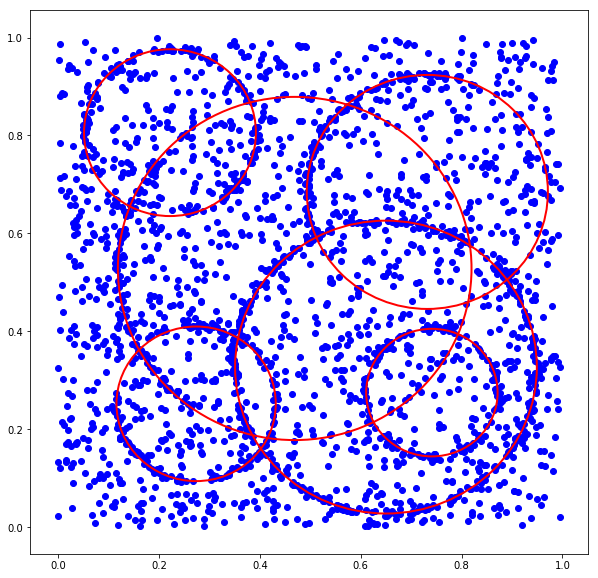

In [92]:
plt.figure(figsize=(10,10))
plt.scatter(data[:,0], data[:,1], color="blue")
for r, U in zip(radii, all_center):
    circle = plt.Circle((U[0], U[1]), radius=r, fill=False, color="red", linewidth=2)
    plt.gca().add_patch(circle)

### 4.2 Algebraic Distance

$$
    \min_{c,r} = \sum_i(\lVert x_i-c \rVert_2^2 - r^2)^2 =
$$

$$
    f_i(c,r) = \lVert x_i-c \rVert_2^2 - r^2 = c^Tc - 2c^Tx_i + x_i^Tx_i - r^2
$$

$$
    \beta := \begin{pmatrix}2c_0\\2c_1\\r^2-c^Tc\end{pmatrix},\qquad \tilde{X}_i=\begin{pmatrix}x_{i0}&x_{i1}&1\end{pmatrix},\qquad \tilde{Y}_i=x_i^Tx_i
$$

$$
    \Rightarrow f_i(c,r) = x_i^Tx_i - \tilde{X}_i\beta = \tilde{Y}_i - \tilde{X}_i\beta
$$

$$
    \hat{c}_1 = \frac{\hat{\beta}_1}{2},\quad \hat{c}_2 = \frac{\hat{\beta}_2}{2},\quad \hat{r} = \sqrt{\hat{\beta}_3+\hat{c}_1^2+\hat{c}_2^2}
$$

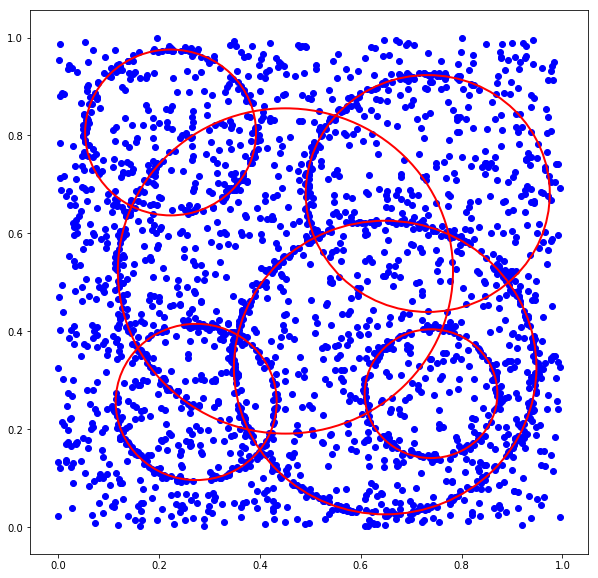

In [148]:
plt.figure(figsize=(10,10))
plt.scatter(data[:,0], data[:,1], color="blue")
for r, U in zip(radii, all_center):
    distances = np.abs(r - np.linalg.norm(data - U, axis=1))
    mask = distances < epsilon
    inliers = data[mask]

    
    X = np.append(inliers, np.ones((len(inliers),1)), axis=1)
    Y = np.sum(inliers*inliers, axis=1)

    beta = np.linalg.pinv(X).dot(Y)

    c_1 = beta[0]/2
    c_2 = beta[1]/2
    radius = np.sqrt(beta[2] + c_1**2 + c_2**2)
    
    circle = plt.Circle((c_1, c_2), radius=radius, fill=False, color="red", linewidth=2)
    plt.gca().add_patch(circle)
    

### 4.3 Levenberg-Marquardt

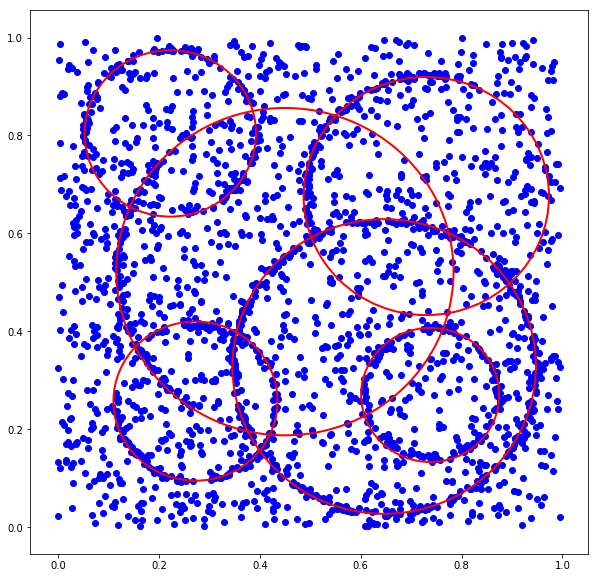

In [149]:
from scipy.optimize import minimize

plt.figure(figsize=(10,10))
plt.scatter(data[:,0], data[:,1], color="blue")
for r, U in zip(radii, all_center):
    distances = np.abs(r - np.linalg.norm(data - U, axis=1))
    mask = distances < epsilon*10
    inliers = data[mask]
    
    def f(p):
        c1, c2, r = p
        c = np.array([c1, c2])
        return ((np.linalg.norm(inliers - c, axis=1) - r)**2).sum()
    
    res = minimize(f, [.5,.5,.5]).x
    circle = plt.Circle((res[0], res[1]), radius=res[2], fill=False, color="red", linewidth=2)
    plt.gca().add_patch(circle)


Both methods give good results.

### 4.4 Comparison

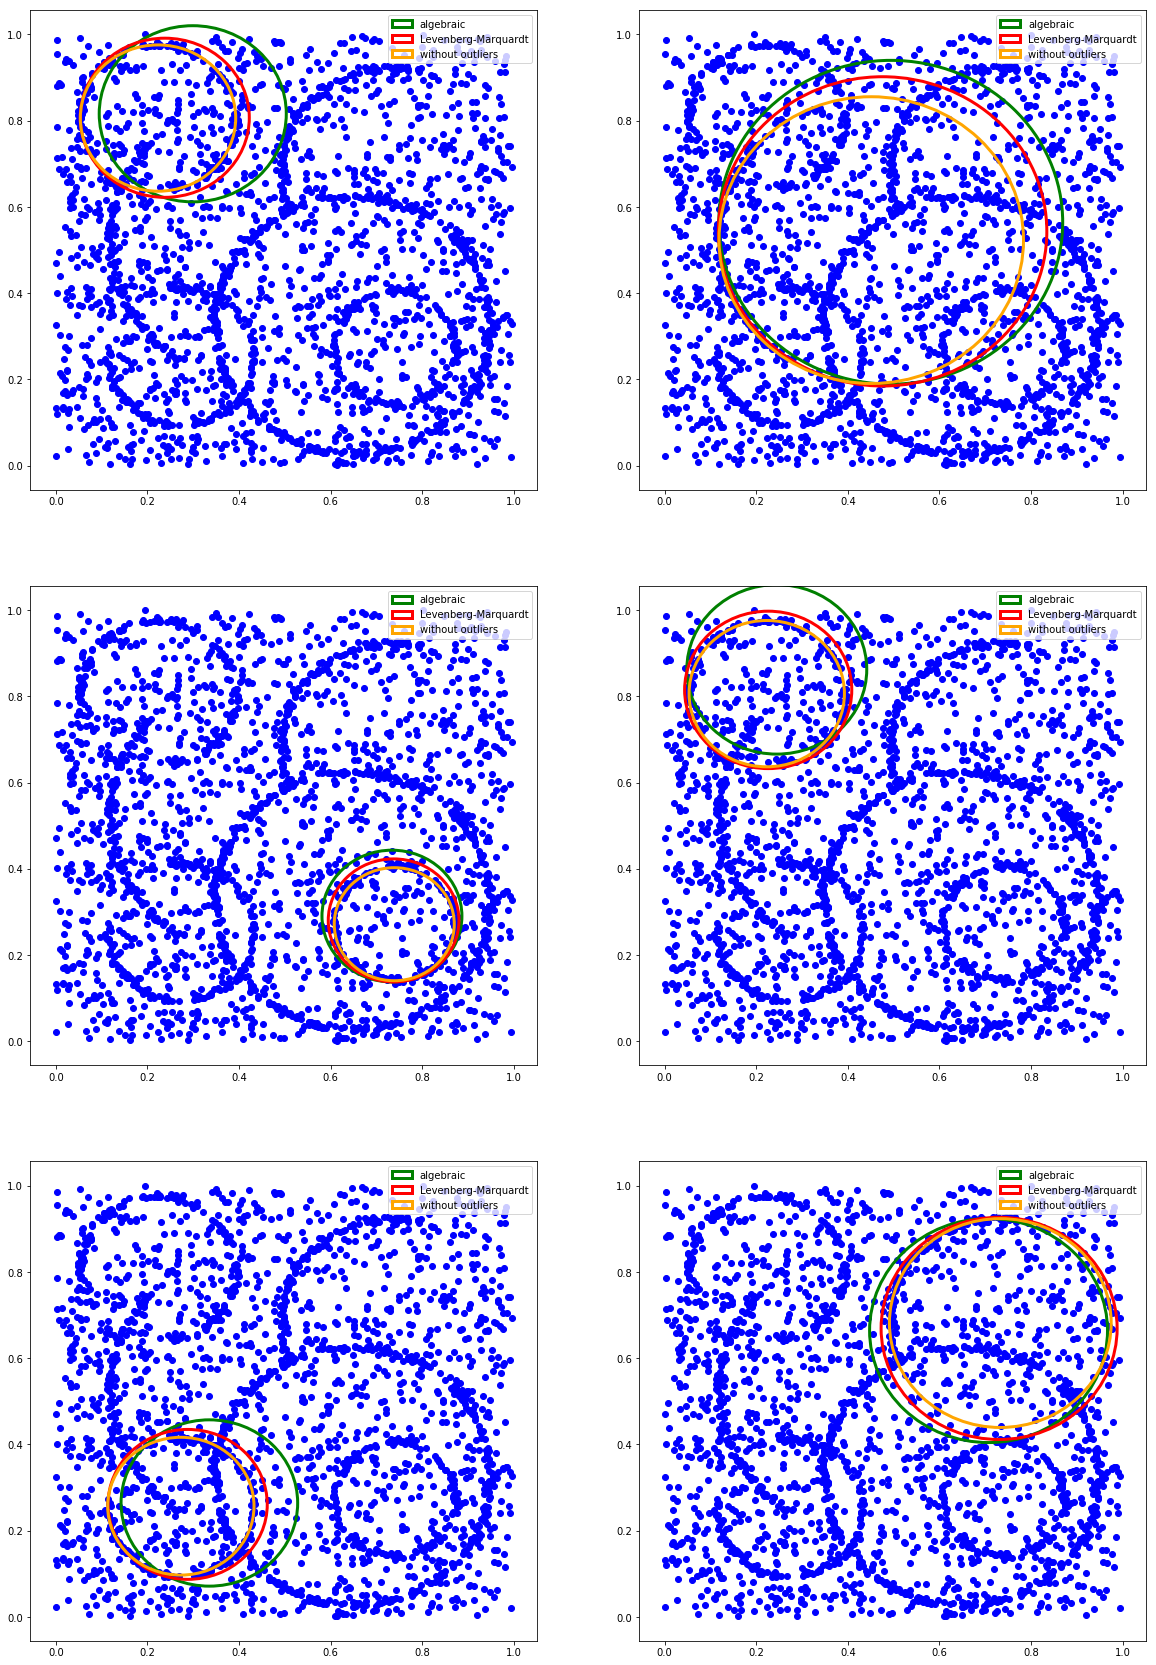

In [157]:
fig, axs = plt.subplots(3, 2, figsize=(20, 30))

for i in range(6):
    axs[i%3, i%2].scatter(data[:,0], data[:,1], color="blue")

    index = np.random.randint(6)
    r = radii[index]
    U = all_center[index]
    inliers = data[np.abs(r - np.linalg.norm(data - U, axis=1)) < epsilon]

    num_outliers = 5
    
    angles = np.random.rand(num_outliers)*2*np.pi
    outlier_radii = np.random.rand(num_outliers)*0.3 + 0.15 + r
    outliers = U + np.array([np.cos(angles), np.sin(angles)]).T*outlier_radii[:,np.newaxis]
    
    #inliers = np.append(inliers, np.random.rand(num_outliers, 2), axis=0)
    inliers = np.append(inliers, outliers, axis=0)
    


    X = np.append(inliers, np.ones((len(inliers),1)), axis=1)
    Y = np.sum(inliers*inliers, axis=1)

    beta = np.linalg.pinv(X).dot(Y)
    c_1 = beta[0]/2
    c_2 = beta[1]/2
    radius = np.sqrt(beta[2] + c_1**2 + c_2**2)
    circle = plt.Circle((c_1, c_2), radius=radius, fill=False, color="green", linewidth=3, label="algebraic")
    axs[i%3, i%2].add_patch(circle)


    def f(p):
        c1, c2, r = p
        c = np.array([c1, c2])
        return ((np.linalg.norm(inliers - c, axis=1) - r)**2).sum()

    res = minimize(f, [.5,.5,.5]).x
    circle = plt.Circle((res[0], res[1]), radius=res[2], fill=False, color="red", linewidth=3, label="Levenberg-Marquardt")
    axs[i%3, i%2].add_patch(circle)

    
    circle = plt.Circle((U[0], U[1]), radius=r, fill=False, color="orange", linewidth=3, label="without outliers")
    axs[i%3, i%2].add_patch(circle)

    axs[i%3, i%2].legend()

As you can see, the result from 4.2 deviates more from the fit without outliers, than the result from 4.3